In [1]:
#!pip install git+git://github.com/andirs/impyte.git

# Response criteria prediction for tumor
Sam Tomioka<br>
2019-10-05

This notebook is for PhUSE AI/ML Project Tumor response prediction challenge using two new dataset provided by Christine Teng.

>In oncology response assessment, regardless if tumor shrinks or disappears, if there are any new lesion, it will be considered progressed (PD).  Also, if the information is not complete, we will consider NE (not evaluable).  I wonder if you can test on these new files.   These are real validated cases (although not all variables are included) and more complete in term of RECIST data to derive target lesion response.   I attached two files, one is assessment by local site and another is by central vendor.  

Data structure
1.	BSUM – Baseline Sum of Diameter
2.	SUMDIAM – Sum of Diameter (Sum of Longest Diameters  and Sum of diameter of non-lymph-node tumor) at current visit
3.	PCBSD – Percent Change From Baseline in Sum of Diameter
4.	NADIR – smallest Sum of Diameter prior to current time point
5.	ACNSD – Absolute Change From Nadir in Sum of Diameter
6.	PCNSD – Percent Change From Nadir in Sum of Diameter
7.	NEWLSN – New Lesion (1-yes,0-no)
8.	TRGRESP – Target Response (PD, CR, PR, SD, NE)


Two data sets will be used for following purposes. 3 ways to generate training data, and 4 ways to generate test data

1. Model based on all of `central` assessments. Test on `site` assessments.
2. Model based on all of  `site` assessments. Test on `central` assessments.
3. Model based on `central`+`site` with 85% of data from each. Test on remaining `central` assessments, Test on remaining `site` assessments independently.
4. ~~Combine both `central` and `site`, add central or site as another feature. Split data randomly and stratify based on the new feature so the distribution of site and central are same in the training and test sets. Use 15% for testing. ~~

In Summary, 

| m | training and validation data |  test data  | test data id |
|---|------------------------------|-------------|--------------|
| 1 | central                      | site        | A            |
| 2 | site                         | central     | B            |
| 3 | central*85%+site*85%         | central*15% | C            |
| 3 | central*85%+site*85%         | site*15%    | D            |


## 1 - Import libraries

!conda install -c conda-forge xgboost -y
import xgboost
xgboost.__version__

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import pickle
import xgboost as xgb
from xgboost import XGBClassifier
from scipy import stats
from impyte import impyte

import sklearn
from sklearn.model_selection import train_test_split\
, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, normalize

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

from lib import myutil
from lib.myutil import *

from matplotlib import pyplot as plt
from matplotlib import cm as cm
import seaborn as sns
%matplotlib inline

print('sklearn=={}\nxgboost=={}'.format(sklearn.__version__,xgb.__version__))

sklearn==0.20.3
xgboost==0.90


## 2 - Import data

In [3]:
central=pd.read_excel(os.path.join('..','data','tumor0central0imp.xls'))
site=pd.read_excel(os.path.join('..','data','tumor0site0imp.xls'))

print('Central: {}\nSite: {}'.format(central.shape, site.shape))

Central: (920, 9)
Site: (695, 9)


In [4]:
col_orders = ['BSUM','SUMDIAM','PCBSD','NADIR','ACNSD','PCNSD','NEWLSN','TRGRESP','EVAL']
central=central[col_orders]
site   =site[col_orders]
central.head()

,BSUM,SUMDIAM,PCBSD,NADIR,ACNSD,PCNSD,NEWLSN,TRGRESP,EVAL
0,53,87.0,64.0,53,34.0,64,1,PD,Central Radiology
1,67,43.0,-36.0,67,-24.0,-36,0,PR,Central Radiology
2,67,29.0,-57.0,43,-14.0,-33,0,CR,Central Radiology
3,67,26.0,-61.0,29,-3.0,-10,0,CR,Central Radiology
4,67,23.0,-66.0,26,-3.0,-12,0,CR,Central Radiology


### 2-1-1. check missing, distribution etc.

In [5]:
check_missing(central,site)

Number of missing in BSUM: 0
Number of missing in SUMDIAM: 30
Number of missing in PCBSD: 30
Number of missing in NADIR: 0
Number of missing in ACNSD: 0
Number of missing in PCNSD: 0
Number of missing in NEWLSN: 0
Number of missing in TRGRESP: 0
Number of missing in EVAL: 0
************************
Number of missing in BSUM: 0
Number of missing in SUMDIAM: 0
Number of missing in PCBSD: 0
Number of missing in NADIR: 0
Number of missing in ACNSD: 0
Number of missing in PCNSD: 0
Number of missing in NEWLSN: 0
Number of missing in TRGRESP: 0
Number of missing in EVAL: 0


#### check the unique missing pattern 

In [6]:
imp = impyte.Impyter(central)
imp.pattern()

,BSUM,SUMDIAM,PCBSD,NADIR,ACNSD,PCNSD,NEWLSN,TRGRESP,EVAL,Count
0,1,1,1,1,1,1,1,1,1,890
1,1,NaN,NaN,1,1,1,1,1,1,30


In [7]:
imp = impyte.Impyter(site)
imp.pattern()

,BSUM,SUMDIAM,PCBSD,NADIR,ACNSD,PCNSD,NEWLSN,TRGRESP,EVAL,Count
0,1,1,1,1,1,1,1,1,1,695


**Missing data were found in central data set only.**

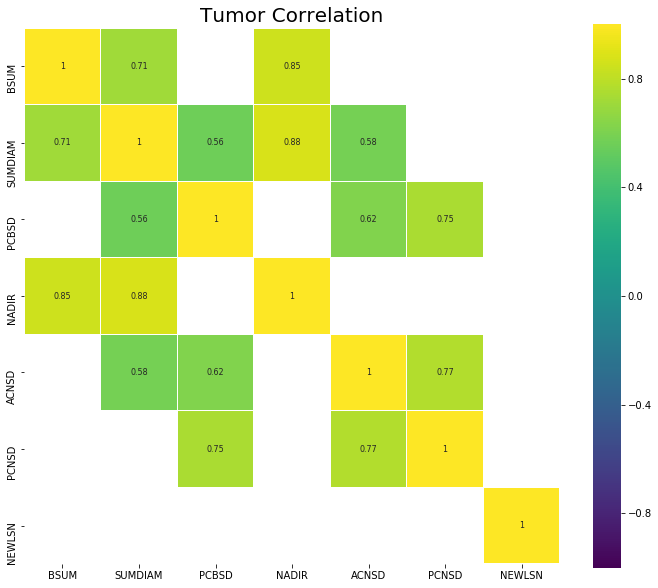

In [8]:
corr_matrix(central)

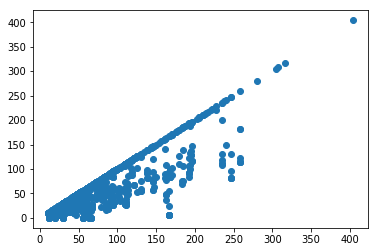

In [9]:
plt.scatter(central['BSUM'], central['NADIR'])
plt.show()

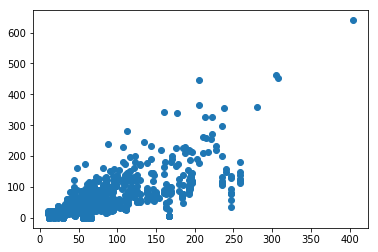

In [10]:
plt.scatter(central['BSUM'], central['SUMDIAM'])
plt.show()

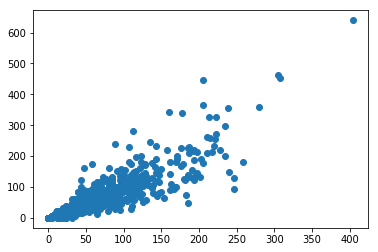

In [11]:
plt.scatter(central['NADIR'], central['SUMDIAM'])
plt.show()

### 2-1-2. - check distribution

### - class variable

In [12]:
unique, counts = np.unique(site['TRGRESP'], return_counts=True)
tr_dist=list(zip(unique,counts/len(site)))

In [13]:
unique, counts = np.unique(central['TRGRESP'], return_counts=True)
list(zip(unique,counts/len(central)))

[('CR', 0.14782608695652175),
 ('NE', 0.05),
 ('PD', 0.1858695652173913),
 ('PR', 0.33804347826086956),
 ('SD', 0.2782608695652174)]

In [14]:
n_class=5
weight_dict={'CR': (1/n_class)/tr_dist[0][1]
            ,'NE': (1/n_class)/tr_dist[1][1]
            ,'PD': (1/n_class)/tr_dist[2][1] 
            ,'PR': (1/n_class)/tr_dist[3][1]
            ,'SD': (1/n_class)/tr_dist[4][1]
            }

#wt_y1 = pd.DataFrame(ts_y1)[0].map(weight_dict)
#wt_y2 = pd.DataFrame(ts_y2)[0].map(weight_dict)
#wt_y3a = pd.DataFrame(ts_y3a)[0].map(weight_dict)
#wt_y3b = pd.DataFrame(ts_y3b)[0].map(weight_dict)

May need to adjust the imbalance

### - covariates (features)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfc3646198>,
      dtype=object)

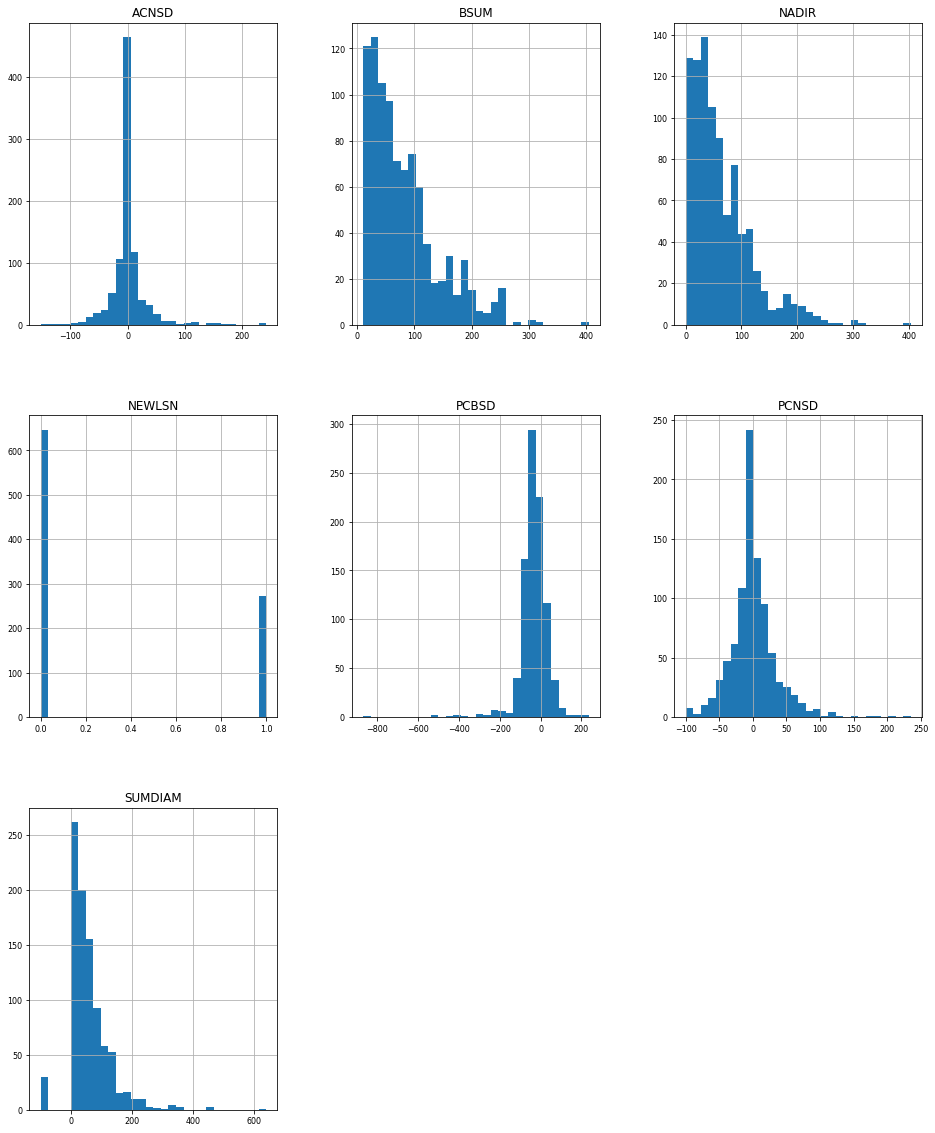

In [15]:
central_i = impute_df(central, -100)
central_i.hist(figsize=(16, 20)
        , bins=30
        , xlabelsize=8
        , ylabelsize=8)

Notice the impuation effect in SUMDIAM.

### - check for confounding

### - check for multicollinearity

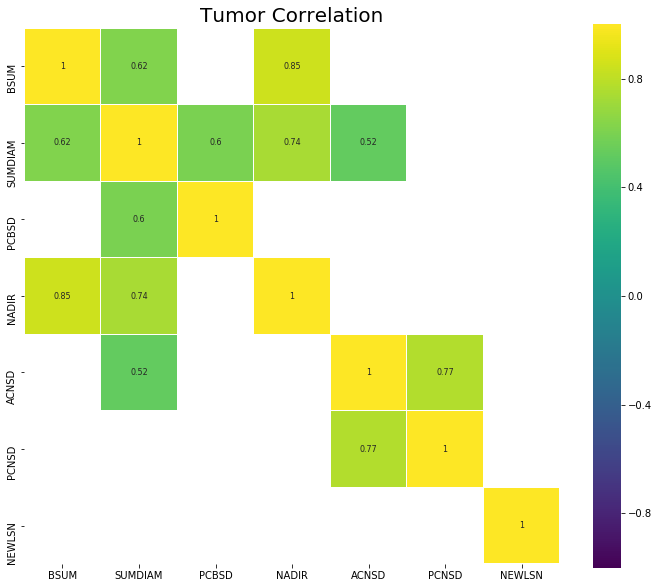

In [16]:
corr_matrix(central_i)

`NADIR` is highly correlated with `BSUM`. May drop it depends on the performance.

## 2-2. missing data imputation

Notes:
### 2-2-1. Missing `PCBSD` depends on missing `SUMDIAM`. Missing `SUMDIAM` is assumed MCAR.

```python
central[central['PCBSD'].isnull()]
```

| idx | BSUM | SUMDIAM | PCBSD | NADIR | ACNSD | PCNSD | NEWLSN | TRGRESP | EVAL              |
|-----|------|---------|-------|-------|-------|-------|--------|---------|-------------------|
| 47  | 35   | NaN     | NaN   | 35    | 57    | 0     | 0      | NE      | Central Radiology |
| 95  | 183  | NaN     | NaN   | 183   | -27.6 | 0     | 0      | NE      | Central Radiology |
| 98  | 183  | 64      | NaN   | 70    | -6    | -9    | 1      | NE      | Central Radiology |
| 123 | 85   | 124     | NaN   | 85    | 39    | 46    | 0      | PD      | Central Radiology |
| 126 | 85   | 118     | NaN   | 85    | 33    | 39    | 0      | PD      | Central Radiology |

### 2-2-2. Imputation of NADIR <This is no longer necessary step>
If `NADIR` is missing, I assume that no post baseline measurement was done, and set it to `NADIR=BSUM`
```python
central[central['NADIR'].isnull()]
```

| idx | BSUM | SUMDIAM | PCBSD | NADIR | ACNSD | PCNSD | NEWLSN | TRGRESP | EVAL              | PCBSD_i |
|-----|------|---------|-------|-------|-------|-------|--------|---------|-------------------|---------|
| 403 | 211  | 211.0   | 0.0   | NaN   | 12.0  | 0     | 0      | NE      | Central Radiology | 0.0     |
| 522 | 61   | 61.0    | 0.0   | NaN   | 0.0   | 0     | 1      | PD      | Central Radiology | 0.0     |
| 546 | 75   | 75.0    | 0.0   | NaN   | 6.0   | 0     | 0      | SD      | Central Radiology | 0.0     |


### 2-2-3. Imputation of PCBSD

```python
central[central['TRGRESP']=='NE']
```

| idx | BSUM | SUMDIAM | PCBSD | NADIR | ACNSD | PCNSD | NEWLSN | TRGRESP | EVAL              |
|-----|------|---------|-------|-------|-------|-------|--------|---------|-------------------|
| 47  | 35   | NaN     | NaN   | 35    | 57    | 0     | 0      | NE      | Central Radiology |
| 95  | 183  | NaN     | NaN   | 183   | -27.6 | 0     | 0      | NE      | Central Radiology |
| 98  | 183  | 64      | -65   | 70    | -6    | -9    | 1      | NE      | Central Radiology |
| 147 | 81   | NaN     | NaN   | 81    | 6     | 0     | 1      | NE      | Central Radiology |
| 188 | 206  | 179     | -13   | 206   | -27   | -13   | 0      | NE      | Central Radiology |

```python
central[central['PCBSD'].isnull()]
```
| idx | BSUM | SUMDIAM | PCBSD | NADIR | ACNSD | PCNSD | NEWLSN | TRGRESP | EVAL              |
|-----|------|---------|-------|-------|-------|-------|--------|---------|-------------------|
| 47  | 35   | NaN     | NaN   | 35    | 57.0  | 0     | 0      | NE      | Central Radiology |
| 95  | 183  | NaN     | NaN   | 183   | -27.6 | 0     | 0      | NE      | Central Radiology |
| 147 | 81   | NaN     | NaN   | 81    | 6.0   | 0     | 1      | NE      | Central Radiology |
| 195 | 126  | NaN     | NaN   | 126   | -14.0 | 0     | 1      | NE      | Central Radiology |
| 209 | 99   | NaN     | NaN   | 99    | -5.0  | 0     | 0      | NE      | Central Radiology |

When `TRGRESP=='NE'`, `PCBSD` is not necessary missing, but when `PCBSD` is missing, `TRGRESP` is always `NE`. 
It is also true that when `PCBSD` is missing, `SUMDIAM` is missing.

Following imputation steps will be taken for `PCBSD`.
1. Impute PCBSD when SUMDIAM is not missing. (This step is no longer neccessary based on the udpated data)
    - method: `PCBSD=100*(SUMDIAM-BSUM)/BSUM`
2. Impute `SUMDIAM` as `h` (see 2-2-4 for justification) and derive PCBSD using `100*(SUMDIAM-BSUM)/BSUM`.    
    
### 2-2-4. Imputation of SUMDIAM

```python
central[central['SUMDIAM'].isnull()]
```
| idx | BSUM | SUMDIAM | PCBSD | NADIR | ACNSD | PCNSD | NEWLSN | TRGRESP | EVAL              |
|-----|------|---------|-------|-------|-------|-------|--------|---------|-------------------|
| 47  | 35   | NaN     | NaN   | 35    | 57.0  | 0     | 0      | NE      | Central Radiology |
| 95  | 183  | NaN     | NaN   | 183   | -27.6 | 0     | 0      | NE      | Central Radiology |
| 147 | 81   | NaN     | NaN   | 81    | 6.0   | 0     | 1      | NE      | Central Radiology |
| 195 | 126  | NaN     | NaN   | 126   | -14.0 | 0     | 1      | NE      | Central Radiology |
| 209 | 99   | NaN     | NaN   | 99    | -5.0  | 0     | 0      | NE      | Central Radiology |

When `SUMDIAM` is missing `central[central['SUMDIAM'].isnull()]`, `TRGRESP` is always 'NE'. 
```
SUMDIAM descriptive stat
count    890.000000
mean      62.989888
std       64.852111
min        0.000000
25%       21.000000
50%       46.000000
75%       86.000000
max      640.000000
```
Based on above, I will set `SUMDIAM` to `h` when SUMDIAM is missing, which is an additional hyperparameter during the model optimization to make the models easier to classify the record as `NE`. The goal is not to predict the RECIST criteria when SUMDIAM is missing but classify it as `NE`.

### 2-2-5. Imputation of NEWLSN
Assume NEWLSN=0 is missing.

### 2-2-6. Imputation in XGB

- Learn the best imputation using the minimal loss

### 2-2-7. Sensitivity analysis
1. median imputation for continuous variables, set to 0 for NEWLSN
2. knn
3. gradient boosting
3. MICE algorithm as described in Van Buuren and Groothuis-Oudshoorn (2011) <-- (use `mice` from `impyte.imputation.cs` or [`mice` package](https://github.com/stefvanbuuren/mice) )
4. no imputation (drop missing)

[1] Azur, Melissa J et al. “Multiple imputation by chained equations: what is it and how does it work?.” International journal of methods in psychiatric research vol. 20,1 (2011): 40-9. doi:10.1002/mpr.329


## 3.  train/evaluate cv results

### 3-1. random forest

In [17]:
grid_param = {
    'n_estimators': np.arange(1000, 3000, 500)
    , 'criterion': ['gini', 'entropy']
    , 'bootstrap': [True, False]
    , 'max_depth': np.arange(5,16,1)
}

val1=central['SUMDIAM'].median()
val2= site['SUMDIAM'].median()

h_lst=[-1000, 0, val1,val2 ,100, 200, 300, 500, 1000, 2000, 3000]

----Training Method: 1----
----------------------
RandomForestClassifier 0  
              h value: -1000
           Parameters: {'n_estimators': 2000, 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
       Validation Acc: 0.8673913043478261
----------------------
RandomForestClassifier 1  
              h value: 0
           Parameters: {'n_estimators': 1000, 'max_depth': 7, 'criterion': 'gini', 'bootstrap': True}
       Validation Acc: 0.8597826086956522
----------------------
RandomForestClassifier 2  
              h value: 46.0
           Parameters: {'n_estimators': 1000, 'max_depth': 7, 'criterion': 'gini', 'bootstrap': True}
       Validation Acc: 0.8510869565217392
----------------------
RandomForestClassifier 3  
              h value: 35.0
           Parameters: {'n_estimators': 1500, 'max_depth': 6, 'criterion': 'entropy', 'bootstrap': True}
       Validation Acc: 0.8565217391304348
----------------------
RandomForestClassifier 4  
              h value: 100
    

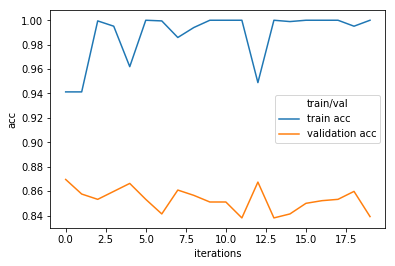

In [18]:
rf1_best_scores, rf1_best_parms, rf1_best_models, rf1_best_idx= run_models(h_lst=h_lst, m=1,grid_param=grid_param, model='rf')

----Training Method: 2----
----------------------
RandomForestClassifier 0  
              h value: -1000
           Parameters: {'n_estimators': 2000, 'max_depth': 12, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.9467625899280575
----------------------
RandomForestClassifier 1  
              h value: 0
           Parameters: {'n_estimators': 1500, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.9496402877697842
----------------------
RandomForestClassifier 2  
              h value: 46.0
           Parameters: {'n_estimators': 2500, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.9482014388489208
----------------------
RandomForestClassifier 3  
              h value: 35.0
           Parameters: {'n_estimators': 2500, 'max_depth': 15, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.9467625899280575
----------------------
RandomForestClassifier 4  
              h value: 100
    

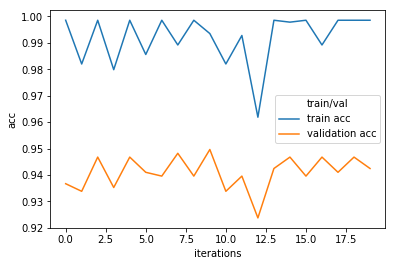

In [19]:
%%time
rf2_best_scores, rf2_best_parms, rf2_best_models, rf2_best_idx= run_models(h_lst=h_lst, m=2,grid_param=grid_param, model='rf')

----Training Method: 3----
----------------------
RandomForestClassifier 0  
              h value: -1000
           Parameters: {'n_estimators': 1500, 'max_depth': 8, 'criterion': 'entropy', 'bootstrap': True}
       Validation Acc: 0.9031318281136198
----------------------
RandomForestClassifier 1  
              h value: 0
           Parameters: {'n_estimators': 2000, 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': False}
       Validation Acc: 0.8994901675163874
----------------------
RandomForestClassifier 2  
              h value: 46.0
           Parameters: {'n_estimators': 1000, 'max_depth': 12, 'criterion': 'entropy', 'bootstrap': False}
       Validation Acc: 0.8936635105608157
----------------------
RandomForestClassifier 3  
              h value: 35.0
           Parameters: {'n_estimators': 1000, 'max_depth': 12, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.8951201747997086
----------------------
RandomForestClassifier 4  
              h value:

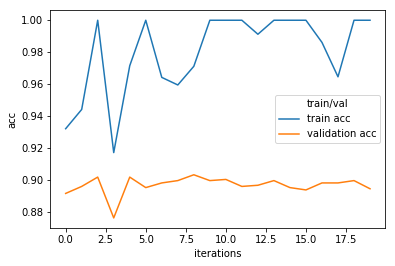

In [20]:
%%time
rf3_best_scores, rf3_best_parms, rf3_best_models, rf3_best_idx= run_models(h_lst=h_lst, m=3,grid_param=grid_param, model='rf')

#### 3-1-1. validation accuracy of top models from 3 methods

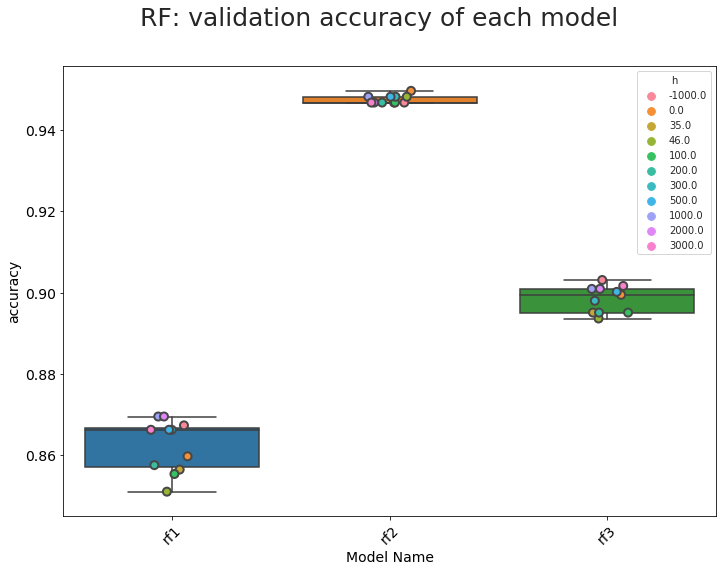

In [21]:
df=pd.DataFrame(
    {'rf1': rf1_best_scores,
     'rf2': rf2_best_scores,
     'rf3': rf3_best_scores,
     'h':h_lst
    })

df=df.melt(id_vars='h', var_name='model name', value_name='accuracy')
plot_model_performance(df, 'RF: validation', hue='h')


In [22]:
df

,h,model name,accuracy
0,-1000.0,rf1,0.867391
1,0.0,rf1,0.859783
2,46.0,rf1,0.851087
3,35.0,rf1,0.856522
4,100.0,rf1,0.855435
5,200.0,rf1,0.857609
6,300.0,rf1,0.866304
7,500.0,rf1,0.866304
8,1000.0,rf1,0.869565
9,2000.0,rf1,0.869565


- save models

In [23]:
best_models=[rf1_best_models, rf2_best_models, rf3_best_models]
save_models(df, mo=best_models)

#### 3-1-2. test-accuracy using 3 best models

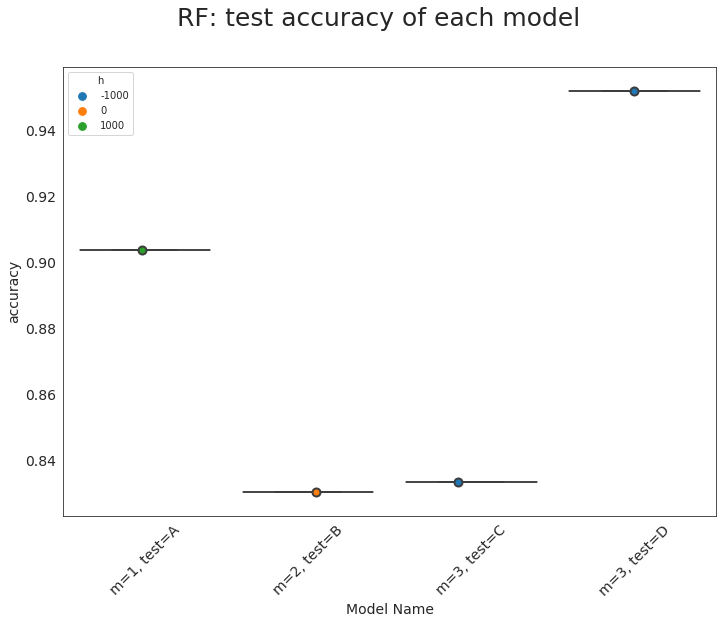

[0.9035971223021583,
 0.8304347826086956,
 0.8333333333333334,
 0.9519230769230769]

In [24]:
best_idx=[rf1_best_idx, rf2_best_idx, rf3_best_idx]

test_accuracy(best_idx, best_models,'RF: test', h_lst)

### 3-2. SVC

In [25]:
svc_grid_param = {
    'tol': [1e-3,1e-4]
    , 'C': stats.expon(scale=1)
    , 'gamma':stats.expon(scale=0.01)

}

----Training Method: 1----
----------------------
SVC 0  
              h value: -1000
           Parameters: {'C': 4.145048043725261, 'gamma': 0.02847735736990811, 'tol': 0.001}
       Validation Acc: 0.7663043478260869
----------------------
SVC 1  
              h value: 0
           Parameters: {'C': 1.8187887752811782, 'gamma': 0.045061927327706724, 'tol': 0.0001}
       Validation Acc: 0.7347826086956522
----------------------
SVC 2  
              h value: 46.0
           Parameters: {'C': 0.9388466893665479, 'gamma': 0.02713957287713155, 'tol': 0.001}
       Validation Acc: 0.6521739130434783
----------------------
SVC 3  
              h value: 35.0
           Parameters: {'C': 5.739838525626067, 'gamma': 0.0288554988932597, 'tol': 0.0001}
       Validation Acc: 0.7565217391304347
----------------------
SVC 4  
              h value: 100
           Parameters: {'C': 1.305676218809692, 'gamma': 0.032899552655838764, 'tol': 0.001}
       Validation Acc: 0.716304347826087
-------

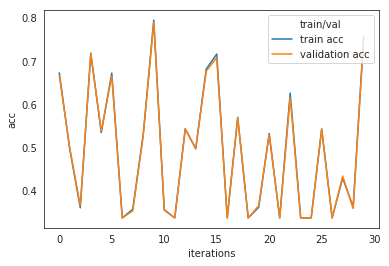

In [26]:
%%time
svc1_best_scores, svc1_best_parms, svc1_best_models, svc1_best_idx= run_models(h_lst=h_lst, m=1,grid_param=svc_grid_param, model='svc')

----Training Method: 2----
----------------------
SVC 0  
              h value: -1000
           Parameters: {'C': 2.09552091290354, 'gamma': 0.02681319487548261, 'tol': 0.0001}
       Validation Acc: 0.7827338129496403
----------------------
SVC 1  
              h value: 0
           Parameters: {'C': 1.4409646400208012, 'gamma': 0.018275742847597733, 'tol': 0.001}
       Validation Acc: 0.7194244604316546
----------------------
SVC 2  
              h value: 46.0
           Parameters: {'C': 3.01757870972157, 'gamma': 0.032405102417649725, 'tol': 0.0001}
       Validation Acc: 0.8287769784172662
----------------------
SVC 3  
              h value: 35.0
           Parameters: {'C': 1.7303485898502962, 'gamma': 0.02456832426828867, 'tol': 0.001}
       Validation Acc: 0.739568345323741
----------------------
SVC 4  
              h value: 100
           Parameters: {'C': 2.8876769493109795, 'gamma': 0.020612068771804496, 'tol': 0.0001}
       Validation Acc: 0.7985611510791367
-----

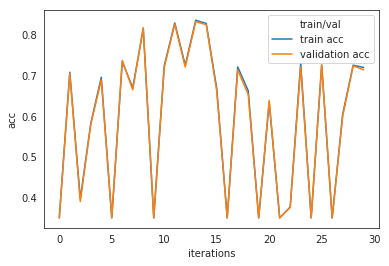

In [27]:
%%time
svc2_best_scores, svc2_best_parms, svc2_best_models, svc2_best_idx= run_models(h_lst=h_lst, m=2,grid_param=svc_grid_param, model='svc')

----Training Method: 3----
----------------------
SVC 0  
              h value: -1000
           Parameters: {'C': 2.9607032034047496, 'gamma': 0.01667537902866952, 'tol': 0.001}
       Validation Acc: 0.7669337217771304
----------------------
SVC 1  
              h value: 0
           Parameters: {'C': 2.6768543418298494, 'gamma': 0.025661006589116308, 'tol': 0.0001}
       Validation Acc: 0.7734887108521485
----------------------
SVC 2  
              h value: 46.0
           Parameters: {'C': 1.859537825949371, 'gamma': 0.038303464715164756, 'tol': 0.0001}
       Validation Acc: 0.774217042971595
----------------------
SVC 3  
              h value: 35.0
           Parameters: {'C': 1.9028781218687416, 'gamma': 0.052297418947707446, 'tol': 0.0001}
       Validation Acc: 0.7851420247632921
----------------------
SVC 4  
              h value: 100
           Parameters: {'C': 1.2870455090041655, 'gamma': 0.037204984369600076, 'tol': 0.001}
       Validation Acc: 0.7676620538965768
-

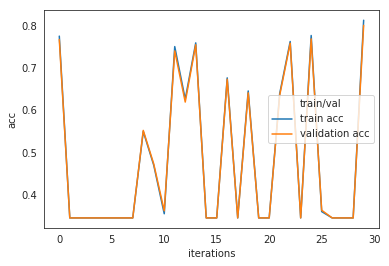

In [28]:
%%time
svc3_best_scores, svc3_best_parms, svc3_best_models, svc3_best_idx= run_models(h_lst=h_lst, m=3,grid_param=svc_grid_param, model='svc')

#### 3-2-1. validation accuracy of top models from 3 methods

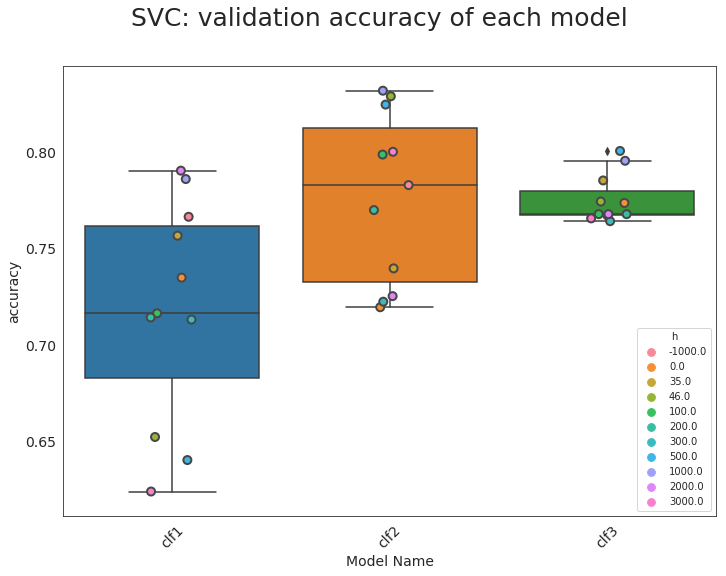

In [29]:
df=pd.DataFrame(
    {'clf1': svc1_best_scores,
     'clf2': svc2_best_scores,
     'clf3': svc3_best_scores,
     'h':h_lst
    })

df=df.melt(id_vars='h', var_name='model name', value_name='accuracy')
plot_model_performance(df, 'SVC: validation', hue='h')


- save models

In [30]:
best_models=  [svc1_best_models
             , svc2_best_models
             , svc3_best_models]
save_models(df, mo=best_models)

#### 3-2-2 test-accuracy using 3 best models

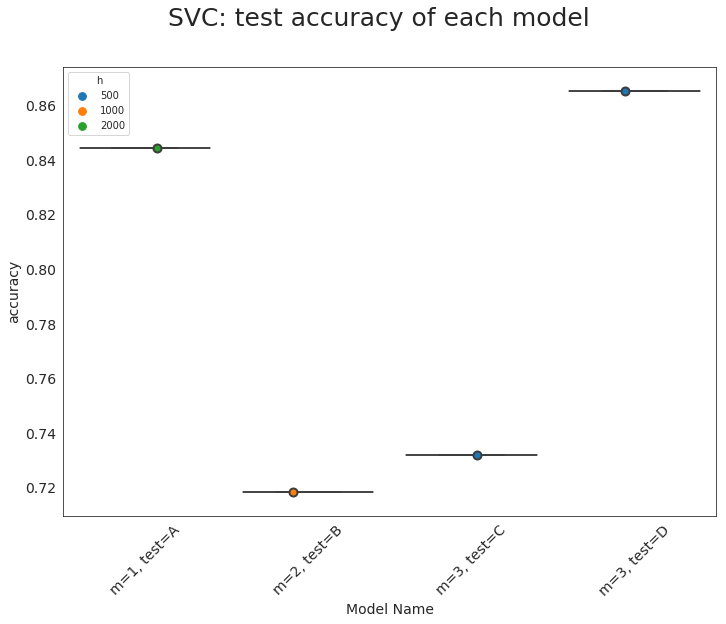

[0.8446043165467626,
 0.7184782608695652,
 0.7318840579710145,
 0.8653846153846154]

In [31]:
best_idx   =  [svc1_best_idx
             , svc2_best_idx
             , svc3_best_idx]
test_accuracy(best_idx, best_models, 'SVC: test', h_lst)

### 3-3. logistic regression

In [32]:
%%time
lr_grid_param = {
    'tol': [1e-3,1e-4]
    , 'C': stats.expon(scale=1)
    , 'solver': ['lbfgs','saga','newton-cg']
    , 'max_iter':[1000, 2000]
}


CPU times: user 2.07 ms, sys: 84 µs, total: 2.15 ms
Wall time: 725 µs


----Training Method: 1----
----------------------
LogisticRegression 0  
              h value: -1000
           Parameters: {'C': 5.059408668636891, 'max_iter': 2000, 'solver': 'saga', 'tol': 0.0001}
       Validation Acc: 0.816304347826087
----------------------
LogisticRegression 1  
              h value: 0
           Parameters: {'C': 3.8741049590981826, 'max_iter': 2000, 'solver': 'lbfgs', 'tol': 0.001}
       Validation Acc: 0.8010869565217391
----------------------
LogisticRegression 2  
              h value: 46.0
           Parameters: {'C': 4.012099303555774, 'max_iter': 1000, 'solver': 'saga', 'tol': 0.0001}
       Validation Acc: 0.7858695652173913
----------------------
LogisticRegression 3  
              h value: 35.0
           Parameters: {'C': 2.2933979045065938, 'max_iter': 2000, 'solver': 'saga', 'tol': 0.001}
       Validation Acc: 0.7739130434782608
----------------------
LogisticRegression 4  
              h value: 100
           Parameters: {'C': 4.14859250176

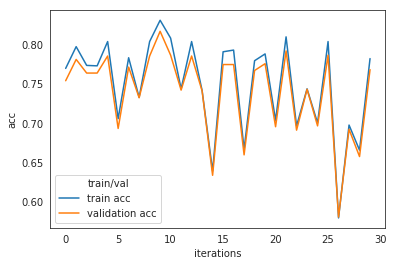

In [33]:
%%time
lr1_best_scores, lr1_best_parms, lr1_best_models, lr1_best_idx= run_models(h_lst=h_lst, m=1,grid_param=lr_grid_param, model='lr')

----Training Method: 2----
----------------------
LogisticRegression 0  
              h value: -1000
           Parameters: {'C': 3.1357096342545066, 'max_iter': 2000, 'solver': 'lbfgs', 'tol': 0.0001}
       Validation Acc: 0.8446043165467626
----------------------
LogisticRegression 1  
              h value: 0
           Parameters: {'C': 3.5595022516729866, 'max_iter': 2000, 'solver': 'saga', 'tol': 0.0001}
       Validation Acc: 0.8503597122302158
----------------------
LogisticRegression 2  
              h value: 46.0
           Parameters: {'C': 3.284357963232618, 'max_iter': 1000, 'solver': 'saga', 'tol': 0.0001}
       Validation Acc: 0.8489208633093526
----------------------
LogisticRegression 3  
              h value: 35.0
           Parameters: {'C': 2.992922802020352, 'max_iter': 2000, 'solver': 'saga', 'tol': 0.0001}
       Validation Acc: 0.8446043165467626
----------------------
LogisticRegression 4  
              h value: 100
           Parameters: {'C': 4.13493434

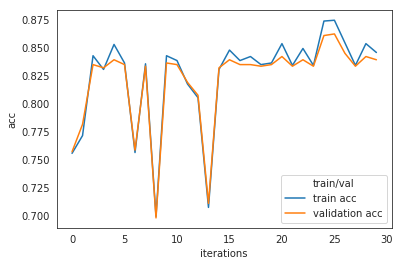

In [34]:
%%time
lr2_best_scores, lr2_best_parms, lr2_best_models, lr2_best_idx= run_models(h_lst=h_lst, m=2,grid_param=lr_grid_param, model='lr')

----Training Method: 3----
----------------------
LogisticRegression 0  
              h value: -1000
           Parameters: {'C': 3.1928886115713713, 'max_iter': 2000, 'solver': 'newton-cg', 'tol': 0.001}
       Validation Acc: 0.8404952658412236
----------------------
LogisticRegression 1  
              h value: 0
           Parameters: {'C': 2.092410797578325, 'max_iter': 1000, 'solver': 'lbfgs', 'tol': 0.0001}
       Validation Acc: 0.8201019664967225
----------------------
LogisticRegression 2  
              h value: 46.0
           Parameters: {'C': 3.8767142239221553, 'max_iter': 1000, 'solver': 'saga', 'tol': 0.0001}
       Validation Acc: 0.833211944646759
----------------------
LogisticRegression 3  
              h value: 35.0
           Parameters: {'C': 3.1560399661769583, 'max_iter': 2000, 'solver': 'saga', 'tol': 0.0001}
       Validation Acc: 0.830298616168973
----------------------
LogisticRegression 4  
              h value: 100
           Parameters: {'C': 4.50709

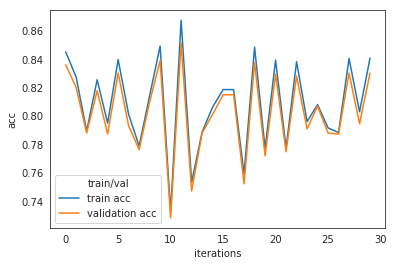

In [35]:
%%time
lr3_best_scores, lr3_best_parms, lr3_best_models, lr3_best_idx= run_models(h_lst=h_lst, m=3,grid_param=lr_grid_param, model='lr')

#### 3-3-1. validation accuracy of top models from 3 methods

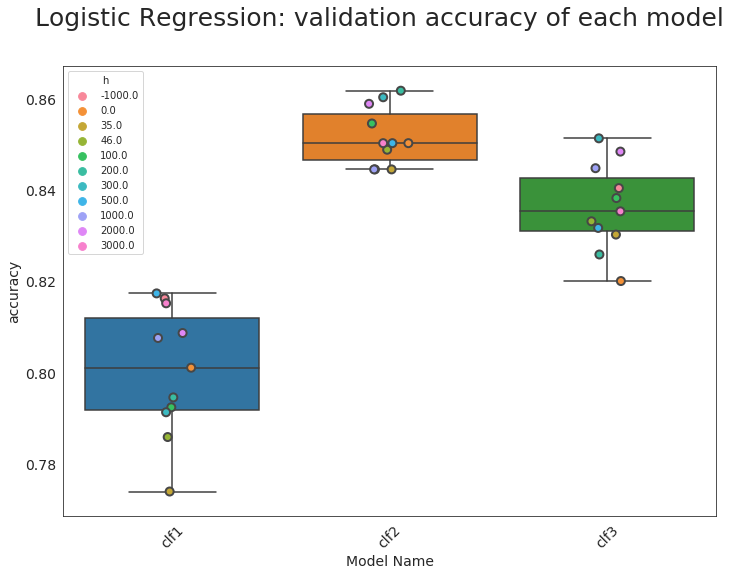

In [36]:
df=pd.DataFrame(
    {'clf1': lr1_best_scores,
     'clf2': lr2_best_scores,
     'clf3': lr3_best_scores,
     'h':h_lst
    })

df=df.melt(id_vars='h', var_name='model name', value_name='accuracy')
plot_model_performance(df, 'Logistic Regression: validation', hue='h')


- save models

In [37]:
best_models=  [lr1_best_models
             , lr2_best_models
             , lr3_best_models]
save_models(df, mo=best_models)

#### 3-3-2. test-accuracy using 3 best models

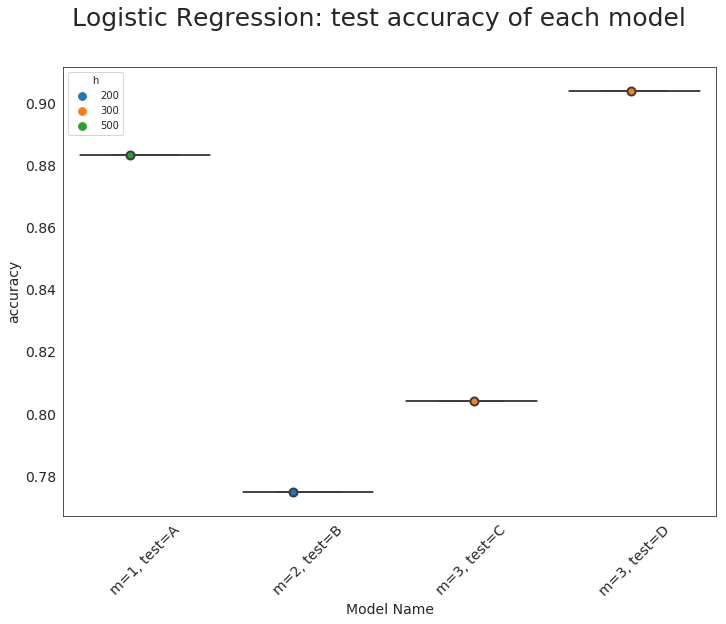

[0.883453237410072, 0.775, 0.8043478260869565, 0.9038461538461539]

In [38]:
best_idx   =  [lr1_best_idx
             , lr2_best_idx
             , lr3_best_idx]


test_accuracy(best_idx, best_models, 'Logistic Regression: test', h_lst)

### 3-4. knn

In [39]:
knn_grid_param = {
            'weights': ['uniform','distance']
            , 'p': [1,2]
            , 'leaf_size': np.arange(10,50,5)
}

----Training Method: 1----
----------------------
KNeighborsClassifier 0  
              h value: -1000
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'uniform'}
       Validation Acc: 0.8206521739130435
----------------------
KNeighborsClassifier 1  
              h value: 0
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'uniform'}
       Validation Acc: 0.8141304347826087
----------------------
KNeighborsClassifier 2  
              h value: 46.0
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'uniform'}
       Validation Acc: 0.8141304347826087
----------------------
KNeighborsClassifier 3  
              h value: 35.0
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'uniform'}
       Validation Acc: 0.8108695652173913
----------------------
KNeighborsClassifier 4  
              h value: 100
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'uniform'}
       Validation Acc: 0.8108695652173913
----------------------
KNeighbo

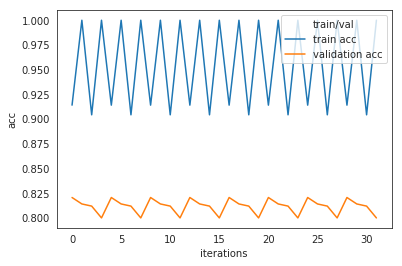

In [40]:
%%time
knn1_best_scores, knn1_best_parms, knn1_best_models, knn1_best_idx= run_models(h_lst=h_lst, m=1,grid_param=knn_grid_param, model='knn')

----Training Method: 2----
----------------------
KNeighborsClassifier 0  
              h value: -1000
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.9079136690647482
----------------------
KNeighborsClassifier 1  
              h value: 0
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.9079136690647482
----------------------
KNeighborsClassifier 2  
              h value: 46.0
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.9079136690647482
----------------------
KNeighborsClassifier 3  
              h value: 35.0
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.9079136690647482
----------------------
KNeighborsClassifier 4  
              h value: 100
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.9079136690647482
----------------------
KNe

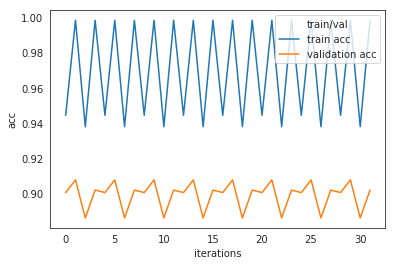

In [41]:
%%time
knn2_best_scores, knn2_best_parms, knn2_best_models, knn2_best_idx= run_models(h_lst=h_lst, m=2,grid_param=knn_grid_param, model='knn')

----Training Method: 3----
----------------------
KNeighborsClassifier 0  
              h value: -1000
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.8798252002913328
----------------------
KNeighborsClassifier 1  
              h value: 0
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.876911871813547
----------------------
KNeighborsClassifier 2  
              h value: 46.0
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.8732702112163147
----------------------
KNeighborsClassifier 3  
              h value: 35.0
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.8747268754552076
----------------------
KNeighborsClassifier 4  
              h value: 100
           Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.8761835396941005
----------------------
KNei

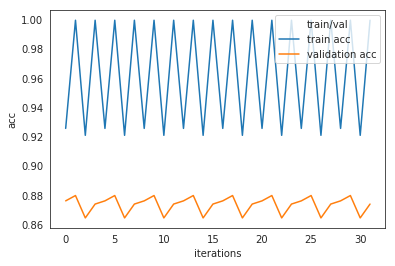

In [42]:
%%time
knn3_best_scores, knn3_best_parms, knn3_best_models, knn3_best_idx= run_models(h_lst=h_lst, m=3,grid_param=knn_grid_param, model='knn')

#### 3-4-1. validation accuracy of top models from 3 methods

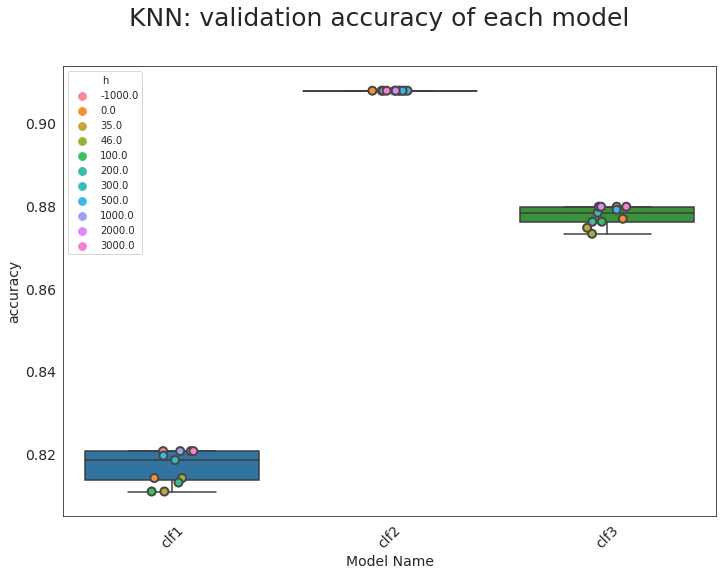

In [43]:
df=pd.DataFrame(
    {'clf1': knn1_best_scores,
     'clf2': knn2_best_scores,
     'clf3': knn3_best_scores,
     'h':h_lst
    })

df=df.melt(id_vars='h', var_name='model name', value_name='accuracy')
plot_model_performance(df, 'KNN: validation', hue='h')


- save models

In [44]:
best_models=  [knn1_best_models
             , knn2_best_models
             , knn3_best_models]
save_models(df, mo=best_models)

#### 3-4-2. test-accuracy using 3 best models

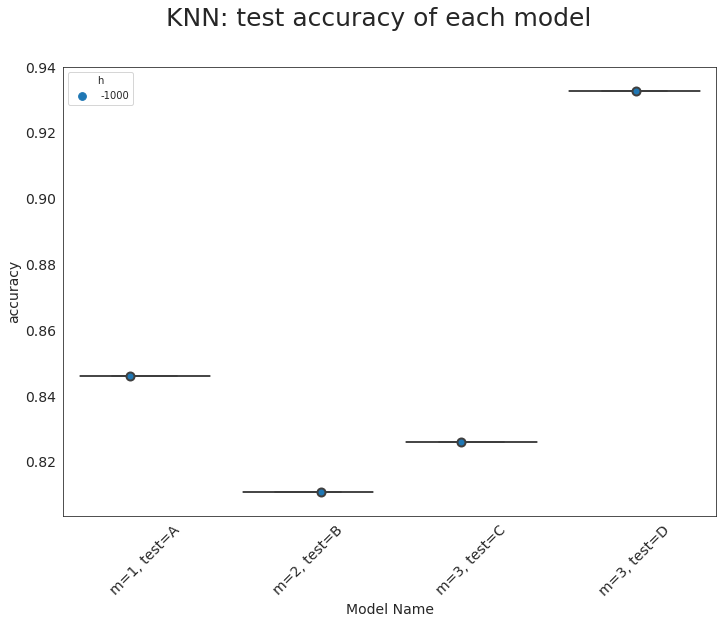

[0.8460431654676259,
 0.8108695652173913,
 0.8260869565217391,
 0.9326923076923077]

In [45]:
best_idx   =  [knn1_best_idx
             , knn2_best_idx
             , knn3_best_idx]


test_accuracy(best_idx, best_models, 'KNN: test', h_lst)

### 3-5. xgboost

In [46]:
xgb_grid_param = {
        'colsample_bytree': np.arange(0.1,1.5,0.1)
        #,'min_child_weight': np.arange(4,8,2)
        ,'gamma': np.arange(0,3,.5)
        ,'colsample_bytree': [0.4, 0.8, 0.1]
        ,'max_depth': np.arange(8,14,1)
        #,'learning_rate': [0.01,0.1]
        #,'n_estimators': [1000, 800]

        }

----Training Method: 1----
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


----------------------
XGBClassifier 0  
              h value: -1000
           Parameters: {'max_depth': 10, 'gamma': 0.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9010869565217391
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


----------------------
XGBClassifier 1  
              h value: 0
           Parameters: {'max_depth': 10, 'gamma': 0.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


----------------------
XGBClassifier 2  
              h value: 46.0
           Parameters: {'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.8934782608695652
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


----------------------
XGBClassifier 3  
              h value: 35.0
           Parameters: {'max_depth': 10, 'gamma': 0.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.8923913043478261
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


----------------------
XGBClassifier 4  
              h value: 100
           Parameters: {'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.8967391304347826
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


----------------------
XGBClassifier 5  
              h value: 200
           Parameters: {'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.8945652173913043
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


----------------------
XGBClassifier 6  
              h value: 300
           Parameters: {'max_depth': 9, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.8967391304347826
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


----------------------
XGBClassifier 7  
              h value: 500
           Parameters: {'max_depth': 12, 'gamma': 0.0, 'colsample_bytree': 0.4}
       Validation Acc: 0.8978260869565218
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


----------------------
XGBClassifier 8  
              h value: 1000
           Parameters: {'max_depth': 9, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


----------------------
XGBClassifier 9  
              h value: 2000
           Parameters: {'max_depth': 10, 'gamma': 0.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9010869565217391
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished


----------------------
XGBClassifier 10  
              h value: 3000
           Parameters: {'max_depth': 9, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9
----------------------
Best XGBClassifier Model: 0
        Parameters: {'max_depth': 10, 'gamma': 0.0, 'colsample_bytree': 0.8} 
                 h: -1000 
    Validation Acc: 0.9010869565217391
CPU times: user 10min 54s, sys: 2.62 s, total: 10min 56s
Wall time: 18min


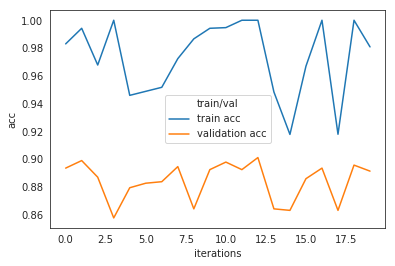

In [47]:
%%time
xgb1_best_scores, xgb1_best_parms, xgb1_best_models, xgb1_best_idx= run_models(h_lst=h_lst, m=1,grid_param=xgb_grid_param, model='xgb')

----Training Method: 2----
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.6s finished


----------------------
XGBClassifier 0  
              h value: -1000
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9669064748201439
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.8s finished


----------------------
XGBClassifier 1  
              h value: 0
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9669064748201439
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.9s finished


----------------------
XGBClassifier 2  
              h value: 46.0
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9669064748201439
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.6s finished


----------------------
XGBClassifier 3  
              h value: 35.0
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9669064748201439
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.4s finished


----------------------
XGBClassifier 4  
              h value: 100
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9669064748201439
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.4s finished


----------------------
XGBClassifier 5  
              h value: 200
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9669064748201439
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.7s finished


----------------------
XGBClassifier 6  
              h value: 300
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9669064748201439
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.6s finished


----------------------
XGBClassifier 7  
              h value: 500
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9669064748201439
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.3s finished


----------------------
XGBClassifier 8  
              h value: 1000
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9669064748201439
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.3s finished


----------------------
XGBClassifier 9  
              h value: 2000
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9669064748201439
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.7s finished


----------------------
XGBClassifier 10  
              h value: 3000
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9669064748201439
----------------------
Best XGBClassifier Model: 0
        Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8} 
                 h: -1000 
    Validation Acc: 0.9669064748201439
CPU times: user 8min 29s, sys: 2.26 s, total: 8min 31s
Wall time: 10min 11s


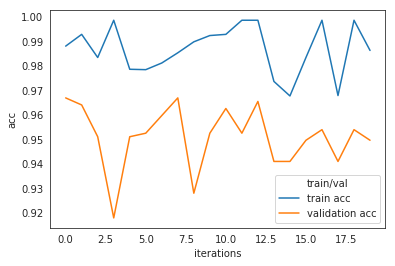

In [48]:
%%time
xgb2_best_scores, xgb2_best_parms, xgb2_best_models, xgb2_best_idx= run_models(h_lst=h_lst, m=2,grid_param=xgb_grid_param, model='xgb')

----Training Method: 3----
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished


----------------------
XGBClassifier 0  
              h value: -1000
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9271667880553532
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.4min finished


----------------------
XGBClassifier 1  
              h value: 0
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9264384559359068
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.4min finished


----------------------
XGBClassifier 2  
              h value: 46.0
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9213401310997815
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.4min finished


----------------------
XGBClassifier 3  
              h value: 35.0
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9198834668608885
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.4min finished


----------------------
XGBClassifier 4  
              h value: 100
           Parameters: {'max_depth': 12, 'gamma': 1.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9184268026219956
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.4min finished


----------------------
XGBClassifier 5  
              h value: 200
           Parameters: {'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9242534595775673
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished


----------------------
XGBClassifier 6  
              h value: 300
           Parameters: {'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9264384559359068
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished


----------------------
XGBClassifier 7  
              h value: 500
           Parameters: {'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9264384559359068
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished


----------------------
XGBClassifier 8  
              h value: 1000
           Parameters: {'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9278951201747997
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished


----------------------
XGBClassifier 9  
              h value: 2000
           Parameters: {'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9278951201747997
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished


----------------------
XGBClassifier 10  
              h value: 3000
           Parameters: {'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9278951201747997
----------------------
Best XGBClassifier Model: 8
        Parameters: {'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.8} 
                 h: 1000 
    Validation Acc: 0.9278951201747997
CPU times: user 16min, sys: 3.22 s, total: 16min 4s
Wall time: 26min 50s


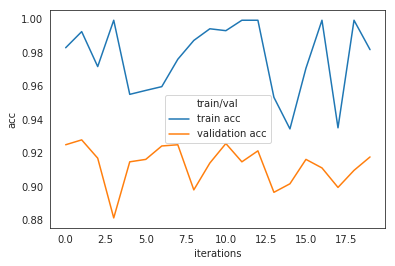

In [49]:
%%time
xgb3_best_scores, xgb3_best_parms, xgb3_best_models, xgb3_best_idx= run_models(h_lst=h_lst, m=3,grid_param=xgb_grid_param, model='xgb')

#### 3-5-1. validation accuracy of top models from 3 methods

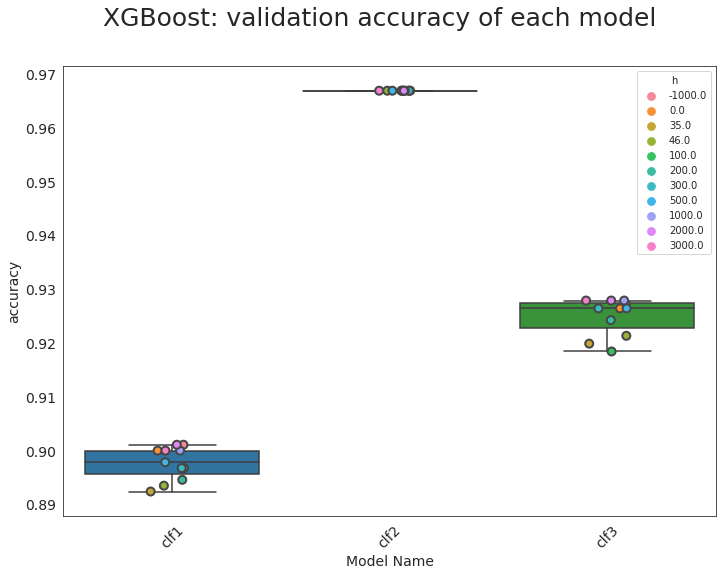

In [50]:
df=pd.DataFrame(
    {'clf1': xgb1_best_scores,
     'clf2': xgb2_best_scores,
     'clf3': xgb3_best_scores,
     'h':h_lst
    })

df=df.melt(id_vars='h', var_name='model name', value_name='accuracy')
plot_model_performance(df, 'XGBoost: validation', hue='h')


- save models

In [51]:
best_models=  [xgb1_best_models
             , xgb2_best_models
             , xgb3_best_models]
save_models(df, mo=best_models)

#### 3-5-2. test-accuracy using 3 best models

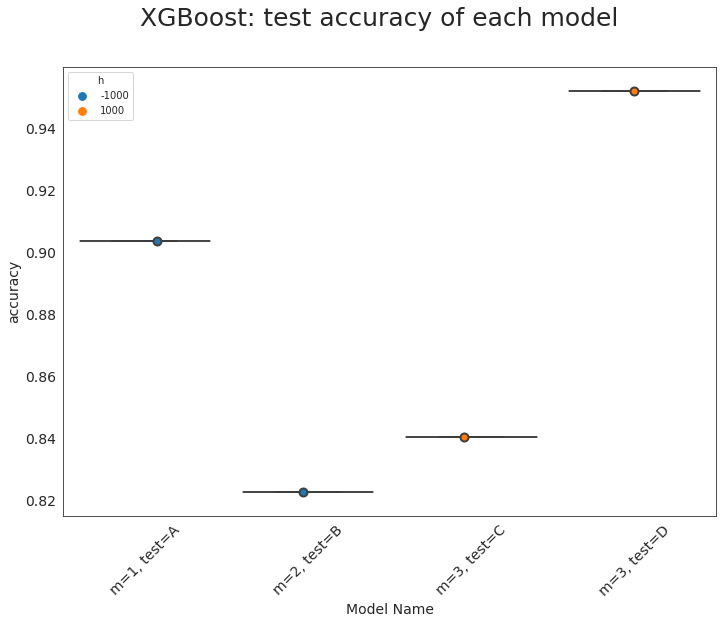

[0.9035971223021583,
 0.8228260869565217,
 0.8405797101449275,
 0.9519230769230769]

In [52]:
best_idx   =  [xgb1_best_idx
             , xgb2_best_idx
             , xgb3_best_idx]


test_accuracy(best_idx, best_models, 'XGBoost: test', h_lst)

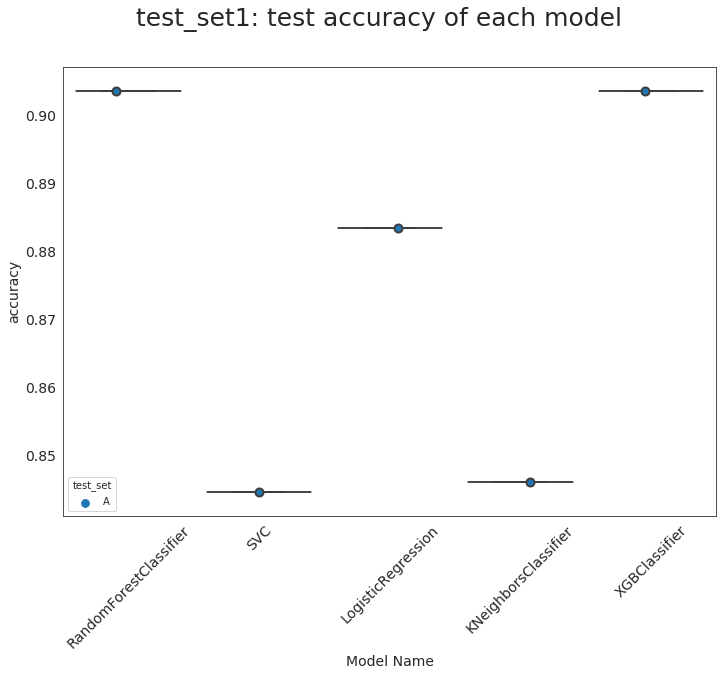

,model name,h,test_set,accuracy
0,RandomForestClassifier,1000,A,0.903597
1,SVC,2000,A,0.844604
2,LogisticRegression,500,A,0.883453
3,KNeighborsClassifier,-1000,A,0.846043
4,XGBClassifier,-1000,A,0.903597


In [53]:
models = [
      rf1_best_models[rf1_best_idx]
    , svc1_best_models[svc1_best_idx]
    , lr1_best_models[lr1_best_idx]    
    , knn1_best_models[knn1_best_idx]
    , xgb1_best_models[xgb1_best_idx]
]
hs = [
      h_lst[rf1_best_idx]
    , h_lst[svc1_best_idx]
    , h_lst[lr1_best_idx]    
    , h_lst[knn1_best_idx]
    , h_lst[xgb1_best_idx]
]
t_df=compare_test(models, hs, 1, 'test_set1: test')
t_df

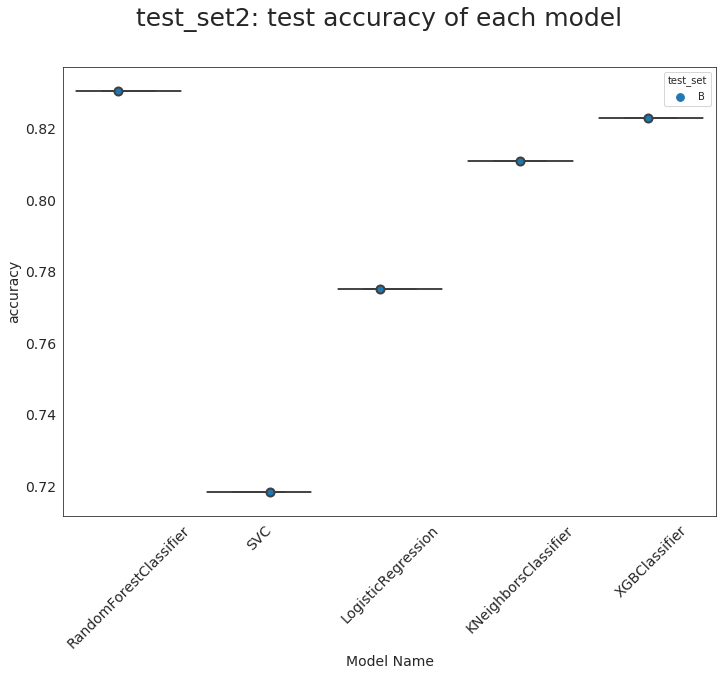

,model name,h,test_set,accuracy
0,RandomForestClassifier,0,B,0.830435
1,SVC,1000,B,0.718478
2,LogisticRegression,200,B,0.775000
3,KNeighborsClassifier,-1000,B,0.810870
4,XGBClassifier,-1000,B,0.822826


In [54]:
models = [
       rf2_best_models[ rf2_best_idx]
    , svc2_best_models[svc2_best_idx]
    ,  lr2_best_models[ lr2_best_idx]    
    , knn2_best_models[knn2_best_idx]
    , xgb2_best_models[xgb2_best_idx]
]
hs = [
      h_lst[ rf2_best_idx]
    , h_lst[svc2_best_idx]
    , h_lst[ lr2_best_idx]    
    , h_lst[knn2_best_idx]
    , h_lst[xgb2_best_idx]
]
t_df=compare_test(models, hs, 2, 'test_set2: test')
t_df

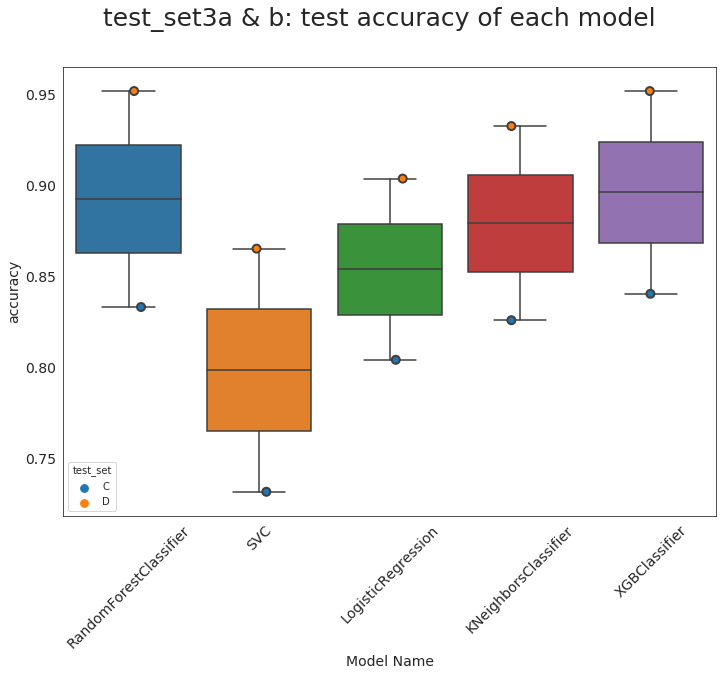

,model name,h,test_set,accuracy
0,RandomForestClassifier,-1000,C,0.833333
1,RandomForestClassifier,-1000,D,0.951923
2,SVC,500,C,0.731884
3,SVC,500,D,0.865385
4,LogisticRegression,300,C,0.804348
5,LogisticRegression,300,D,0.903846
6,KNeighborsClassifier,-1000,C,0.826087
7,KNeighborsClassifier,-1000,D,0.932692
8,XGBClassifier,1000,C,0.840580
9,XGBClassifier,1000,D,0.951923


In [55]:
models = [
       rf3_best_models[ rf3_best_idx]
    , svc3_best_models[svc3_best_idx]
    ,  lr3_best_models[ lr3_best_idx]    
    , knn3_best_models[knn3_best_idx]
    , xgb3_best_models[xgb3_best_idx]
]
hs = [
      h_lst[ rf3_best_idx]
    , h_lst[svc3_best_idx]
    , h_lst[ lr3_best_idx]    
    , h_lst[knn3_best_idx]
    , h_lst[xgb3_best_idx]
]
t_df=compare_test(models, hs, 3, 'test_set3a & b: test')
t_df

## Summary



Five algorithms were tested to predict RECIST responses including not evaluable. All these algorithms consistently outperformed on test data consiste of only site assessments when the models were trained using the data from central assessments or the combination of central and sites. The accuracy rate was below 90% for central assessment.

Various imputation values were used for SUMDIAM to train the models and confirmed that the imputation values do affect the performance of the models. No statistical evaluation on the impact of each imputation value was not performed. Other parametric and non-parametric imputation methods will be evaluated for the training data to see whether these affect the performance of the models.